## Things to do

* Done: Ask Hans what a good cosmic ray flux ange distribution is
* Done: Plot Cos^2 distribution, that I get out of the generator funciton, plot a cos^2 for comparison over it
  * Done: Do this for the uncorrected and corrected method
* Done: Correct Cos^2 angles generation method (not in x-y-direction the cos^2, but cos^2 in polar angle and then uniform in azimuthal angle)
* Done: Plot the values for a round detector (calculated analytically) over the monte carlo
* Done, but its strange: Plot the values for a round detector (as a monte carlo) over the monte carlo

### Imports

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import os
import time
import pandas as pd
from scipy.optimize import curve_fit
import inspect
from iminuit import Minuit, describe, Struct
from scipy.misc import derivative
from IPython.core.debugger import set_trace
import pickle

### Settings

In [3]:
# settings
scintillator_slab_geometry = (0.2, 0.2) # 2 dimensional geometry in meters
scintillator_slab_thickness = 0.028
current_setup_distance = 2*scintillator_slab_thickness
np.random.seed(42)
discrete_probability_step_size = 0.001

# not yet implemented settings
simulation_lenght_seconds = 60*60*10
# measured detector efficency
#scintillator_eff = (0.9897166842, 0.9850746269, 0.9957219251)
scintillator_eff = (1, 1, 1)

### Functions

In [4]:
_Hebbeker_normation = 0.0206865
_Hebbeker_factors = [0.018420759916164563,
                    -0.05409701020482868,
                    0.062345742045134364,
                    0.017889583588494178]
_Hebbeker_formula_assembly = lambda x: (_Hebbeker_factors[0]+
                                        _Hebbeker_factors[1]*np.cos(x)+
                                        _Hebbeker_factors[2]*np.cos(x)+
                                        _Hebbeker_factors[3]*np.cos(2*x))

# if somebody wants his arguments optimized, they should be set as defaults, as a tupel, called "custom_args" 
available_angle_generators = {"Cos^2": lambda x: np.square(np.cos(x))*4/np.pi,
                              "Cos^n": lambda x, n=2: np.power(np.cos(x), n)*4/np.pi,
                               "Biallass&Hebbeker": lambda x, n=2: _Hebbeker_formula_assembly(np.pi-x)/_Hebbeker_normation
                              }

class Simulated_Detector():
    # constants for all detectors
    # theoretical counts per m^2 per second per angle_element see: http://web.mit.edu/8.13/www/JLExperiments/JLExp14.pdf
    counts_per_m_s_angle_element = 83.0  # m^−2 s^−1 sr^−1
    # theoretical counts per m^2 per second for the whole sphere, see: Muon_flux_calculation.nb
    counts_per_m_s_whole_sphere = 173.835  # m^−2 s^−1
    
    def __init__(self, detector_geometry, isRound, scintillator_eff, discrete_probability_step_size, use_deprecated_angle_calculation=False, angle_density_function_name="Biallass&Hebbeker", enable_multi_threading=True):
        self._detector_geometry = detector_geometry
        self._isRound = isRound
        self._scintillator_eff = np.asarray(scintillator_eff)
        self._discrete_probability_step_size = discrete_probability_step_size
        self._useOldAngleGenerator = use_deprecated_angle_calculation
        self._angle_density_function_name = angle_density_function_name
        self._enable_multi_threading = enable_multi_threading
        self._additional_angle_generation_parameters = {}
        self._external_data = None
        self._rate_to_norm_to = 1
    
    def get_detector_area(self):
        return self._detector_geometry[0]*self._detector_geometry[1]
    
    def get_detector_efficiency(self):
        return self._scintillator_eff[0]*self._scintillator_eff[1]*self._scintillator_eff[2]
    
    # function to generate angles for cosmics
    # The known probability density function is Cos^2 from -Pi/2 to Pi/2
    # Sample from this analytically one would calculate the cumulative propability density, then the inverse.
    # To sample one then generates unifrom values from 0 to 1 and inserts them into the calculated inverse
    # Unfortunatley this is not possible in an analytical way (see Mathematica "Inverse_calucalation.nb")
    # Instead we sample the probability density function piecwiese and then choose randomly from these equidistant, but weighted choices
    # Notice: Each sample step is of constant height, thus with low sample rate the error will become significant
    def _generate_cosmics_angles_kartesian(self, num_Angles=1):
        # sample from cos^2 (from 0 to Pi/2)
        sample_steps = np.arange(0, np.pi/2, self._discrete_probability_step_size)
        discrete_probabilities = available_angle_generators[self._angle_density_function_name](sample_steps)
        discrete_probabilities_normed = discrete_probabilities/discrete_probabilities.sum()
        angles = np.random.choice(np.arange(0,np.pi/2,discrete_probability_step_size), p=discrete_probabilities_normed, size=(num_Angles,2))
        # Determine random direction of the angle, since cos^2 is semetrical
        angles_direction = np.random.choice([-1,1],size=angles.shape)
        final_angles = angles*angles_direction
        return final_angles

    def _generate_cosmics_angles_polar(self, num_Angles=1):
        # sample from cos^2 (from 0 to Pi/2)
        sample_steps = np.arange(0, np.pi/2, self._discrete_probability_step_size)
        discrete_probabilities = available_angle_generators[self._angle_density_function_name](sample_steps, **self._additional_angle_generation_parameters)
        discrete_probabilities *= np.sin(sample_steps)*np.cos(sample_steps)
        discrete_probabilities_normed = discrete_probabilities/discrete_probabilities.sum()
        # generate angles
        polar_angles = np.random.choice(np.arange(0,np.pi/2,discrete_probability_step_size), p=discrete_probabilities_normed, size=num_Angles)
        azimuthal_angles = np.random.uniform(0, 2*np.pi, size=num_Angles)
        # bring angles into a fittin array
        final_angles = np.concatenate((polar_angles, azimuthal_angles), axis=0)
        final_angles = final_angles.reshape((num_Angles,2), order='F')
        return final_angles
    
    
    # function to generate positions on the detector
    # sampled uniformly within the detector size
    def _generate_positions(self, num_pos=1):
        if self._isRound:
            radius = np.sqrt(self.get_detector_area()/np.pi)
            
            # calculation taken from: https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly
            t = 2*np.pi*np.random.uniform(0, 1, size=num_pos)
            u = np.random.uniform(0, 1, size=num_pos) + np.random.uniform(0, 1, size=num_pos)
            #r = if u>1 then 2-u else u
            r = np.where(u>1, 2-u, u)
            r *= radius
            
            x = r*np.cos(t)
            y = r*np.sin(t)
        else:
            x = np.random.uniform(0, self._detector_geometry[0], size=num_pos)
            y = np.random.uniform(0, self._detector_geometry[1], size=num_pos)
        combined_array = np.concatenate((x,y), axis=0)
        return combined_array.reshape((num_pos,2), order='F')

    # Calculate the position on the other detector
    def _calculate_position_on_second_detector_kartesian_angles(self, pos_det1, angles, detector_distance):
        return np.tan(angles)*detector_distance+pos_det1

    def _calculate_position_on_second_detector_polar_angles(self, pos_det1, angles, detector_distance):
        # calculate position on second detector
        r = np.tan(angles[...,0])*detector_distance
        x = r*np.cos(angles[...,1]) + pos_det1[...,0]
        y = r*np.sin(angles[...,1]) + pos_det1[...,1]

        det2_pos = np.concatenate((x,y), axis=0)
        det2_pos = det2_pos.reshape((len(x),2), order='F')
        return det2_pos

    # filter out events that are not on the detector area
    def _filter_out_of_bounds(self, positions):
        if self._isRound:
            radius = np.sqrt(self.get_detector_area()/np.pi)
            # calculate distance from center
            distance_from_0 = np.sqrt(np.square(positions[...,0]) + np.square(positions[...,1]))
            reduced = positions[distance_from_0<=radius,:]
            return reduced
        else:
            # check the x-axis
            axis = 0
            checked_x_max = positions[positions[...,axis] <= self._detector_geometry[axis]]
            checked_x_max_min = checked_x_max[checked_x_max[...,axis] >= 0]
            # check the y-axis
            axis = 1
            checked_y_max = checked_x_max_min[checked_x_max_min[...,axis] <= self._detector_geometry[axis]]
            checked_y_max_min = checked_y_max[checked_y_max[...,axis] >= 0]
            return checked_y_max_min

    def _simulate_loss_due_to_distance_old_kartesian(self, distance, events_to_generate=100000):
        cosmics_angles = self._generate_cosmics_angles_kartesian(num_Angles = events_to_generate)
        cosmics_pos_det1 = self._generate_positions(num_pos = events_to_generate)

        # calculate positions on other detector
        cosmics_pos_det2 = self._calculate_position_on_second_detector_kartesian_angles(cosmics_pos_det1, cosmics_angles, distance)

        # filter out events that are not seen on the other detector
        in_bounds = self._filter_out_of_bounds(cosmics_pos_det2)
        loss = float(len(in_bounds))/events_to_generate
        loss_error = loss*np.sqrt(len(in_bounds))/len(in_bounds)

        return np.asarray((loss, loss_error))

    def _simulate_loss_due_to_distance_polar(self, distance, events_to_generate=100000):
        cosmics_angles = self._generate_cosmics_angles_polar(num_Angles = events_to_generate)
        cosmics_pos_det1 = self._generate_positions(num_pos = events_to_generate)

        # calculate positions on other detector
        cosmics_pos_det2 = self._calculate_position_on_second_detector_polar_angles(cosmics_pos_det1, cosmics_angles, distance)

        # filter out events that are not seen on the other detector
        in_bounds = self._filter_out_of_bounds(cosmics_pos_det2)
        loss = float(len(in_bounds))/events_to_generate
        loss_error = loss*np.sqrt(len(in_bounds))/len(in_bounds)

        return np.asarray((loss, loss_error))
    
    def _simulate_loss_due_to_distance(self, distance, events_to_generate):
        if self._useOldAngleGenerator:
            return self._simulate_loss_due_to_distance_old_kartesian(distance, events_to_generate=events_to_generate)
        else:
            return self._simulate_loss_due_to_distance_polar(distance, events_to_generate=events_to_generate)
    
    def simulate_rate(self, distance, seconds_to_simulate):
        # calculate how many muons would hit one of the scintillators over the given time
        expected_count_per_scintillator = int(self.counts_per_m_s_whole_sphere * self.get_detector_area() * seconds_to_simulate)

        # simulate the loss due to distance
        expected_loss = self._simulate_loss_due_to_distance(distance, expected_count_per_scintillator)

        # calculate the rate
        estimated_rate_and_error = expected_count_per_scintillator * expected_loss / seconds_to_simulate

        # reduce by the detector efficiency
        estimated_rate_and_error = estimated_rate_and_error * self.get_detector_efficiency()
        return estimated_rate_and_error
    
    def simulate_rate_over_distance_range(self, distance_range, seconds_to_simulate):
        # calculate the rate for all distances
        rates = np.zeros(shape=(len(distance_range),2))
        for i in range(len(distance_range)):
            current_dist = distance_range[i]
            rates[i] = self.simulate_rate(current_dist, seconds_to_simulate)
        
        return rates
        
    def analytical_round_detector_rate(self, distance):
        factors = 2 * np.pi * self.get_detector_efficiency() * self.counts_per_m_s_angle_element * self.get_detector_area() / 3
        result = factors * (1 - np.power(np.cos(np.arctan(np.sqrt(self.get_detector_area()) / (2 * distance))),3))
        return result
    
    def set_external_data(self, data_x, data_err_x, data_y, data_err_y, rate_to_norm_to):
        data = pd.DataFrame.from_dict({'x':data_x, 'dx':data_err_x, 'y':data_y, 'dy':data_err_y})
        data = data.reset_index(drop=True)
        self._external_data = data
        self._rate_to_norm_to = rate_to_norm_to
    
    def _get_chi2_for_data(self, seconds_to_simulate=60*60*5):
        data = self._external_data
        rate_to_norm_to = self._rate_to_norm_to[0]

        # do the simulation
        rates = self.simulate_rate_over_distance_range(data['x'], seconds_to_simulate)[...,0]
        # scale the rates
        rate_norming_factor = rate_to_norm_to/rates.max()
        rates *= rate_norming_factor
        
        # calculate the error coming from dx
        '''
        func_to_diff = lambda x: rate_norming_factor * self.simulate_rate(x, seconds_to_simulate)[0]
        sim_diff = np.zeros(len(data['x']))
        sim_errors_x = np.zeros(len(data['x']))
        for i in range(len(data['x'])):
            diff = derivative(func_to_diff, data['x'][i], dx=1e-6, order=5)
            sim_diff[i] = diff
            sim_errors_x[i] = np.sqrt(np.square(sim_diff[i]) * np.square(data['dx'][i]))
        
        # calculate the total expected error
        sim_error = np.sqrt(np.square(data['dy']) + np.square(sim_errors_x))
        '''
        
        sim_error = data['dy']

        # calculate chi2
        chi2 = 0
        for i in range(len(data['x'])):
            out = np.square(rates[i] - data['y'][i])
            out /= np.square(sim_error[i])
            chi2 += out

        return chi2
    
    def _get_optional_angle_parameters_and_defaults(self):
        if self._angle_density_function_name == "Cos^n":
            return (["n"],[2])
        raw_parameter_data = inspect.signature(available_angle_generators[self._angle_density_function_name]).parameters
        parameter_list = describe(available_angle_generators[self._angle_density_function_name])
        parameter_list.pop(0)
        defaults = []
        for parameter in parameter_list:
            defaults.append(raw_parameter_data[parameter].default)
        return parameter_list, defaults

    def _set_custom_angle_parameters(self, parameter_names, parameter_values):
        available_parameters = self._get_optional_angle_parameters_and_defaults()[0]
        # correctness checks
        if len(parameter_names) != len(available_parameters):
            raise RuntimeError("The angle generator {0} needs exactly these parameters {1}, but {2} was supplied!".format(self._angle_density_function_name, parameter_names, available_parameters))
        for p in parameter_names:
            if p not in available_parameters:
                raise RuntimeError("The angle generator {0} needs exactly these parameters {1}, but {2} was supplied!".format(self._angle_density_function_name, parameter_names, available_parameters))
        # assemble the dictionary with optional parameters
        parameters_dict = {}
        for i in range(len(parameter_names)):
            parameters_dict[parameter_names[i]] = parameter_values[i]
        # set the parameters that are beeing optimized
        self._additional_angle_generation_parameters = parameters_dict

    def _clear_custom_angle_parameters(self):
        self._additional_angle_generation_parameters = {}
        
    def optimize_angle_generator_to_data(self, seconds_to_simulate=60*60*5):
        data = self._external_data
        rate_to_norm_to = self._rate_to_norm_to
        
        print("Setting Minuit up")
        parameters_to_opt = self._get_optional_angle_parameters_and_defaults()

        # check if we can even optimize this angle generator
        if len(parameters_to_opt[0]) == 0:
            print("The angle generator {} does not support optimization!".format(self._angle_density_function_name))
            print("The chosen angle generator ({}) has no optional parameters; these are used for optimization. Please choose a different generator.".format(self._angle_density_function_name))
            raise RuntimeError("The angle generator {} does not support optimization!".format(self._angle_density_function_name))

        # create our optimization function
        def func_for_optimization(*args):
            self._set_custom_angle_parameters(parameters_to_opt[0], np.array(args))
            # reset the random seed
            np.random.seed(42)
            chi2 = self._get_chi2_for_data(seconds_to_simulate=seconds_to_simulate)
            self._clear_custom_angle_parameters()
            return chi2

        # create the dictionary to tell Minuit how to talk to the function
        kwargs = {}
        kwargs["forced_parameters"] = parameters_to_opt[0]
        for i in range(len(parameters_to_opt[0])):
            para = parameters_to_opt[0][i]
            kwargs[para] = parameters_to_opt[1][i]
            kwargs["error_" + para] = 0.1
            kwargs["limit_" + para] = (0.1, 4.0)

        # create the Minuit optimizer
        m = Minuit(func_for_optimization,
                   errordef=1.0, print_level=1,
                   **kwargs)

        print("Running Minuit")
        m.migrad();

        return m
    
    def scan_angle_gnerator_parameter(self, parameter_name, parameter_range, seconds_to_simulate = 60*60*5):
        # store the results in an dataframe
        result = pd.DataFrame(data={parameter_name:parameter_range})
        result["chi2"] = np.nan

        for value in result[parameter_name]:
            print("Current scan value: {:.2f}".format(value))
            self._set_custom_angle_parameters([parameter_name], np.array([value]))
            # calculate chi2
            chi2 = self._get_chi2_for_data(seconds_to_simulate=seconds_to_simulate)
            result.loc[result[parameter_name] == value, 'chi2'] = chi2
            self._clear_custom_angle_parameters()
            

        return result
           
        
    
    
def test_angel_gnerator(detector, num_bins, events_to_generate):
    test_angles = detector._generate_cosmics_angles_polar(num_Angles = events_to_generate)
    
    # check polar angle
    plt.title("Distribution of polar angles")
    n, bins, patches = plt.hist(test_angles[...,0], bins=num_bins, normed=True, label="Generated polar angles")
    x_points_to_plot = []
    for i in range(len(bins)-1):
        x_points_to_plot.append((bins[i]+bins[i+1])/2)
    x_points_to_plot = np.asarray(x_points_to_plot)
    plt.plot(x_points_to_plot, available_angle_generators[detector._angle_density_function_name](x_points_to_plot)*np.cos(x_points_to_plot)*np.sin(x_points_to_plot), label="Expected density: "+detector._angle_density_function_name)
    plt.legend()
    plt.show()

    # check azimuthal angel
    plt.title("Distribution of azimuthal angles")
    n, bins, patches = plt.hist(test_angles[...,1], bins=num_bins, normed=True, label="Generated azimuthal angles")
    x_points_to_plot = []
    for i in range(len(bins)-1):
        x_points_to_plot.append((bins[i]+bins[i+1])/2)
    x_points_to_plot = np.asarray(x_points_to_plot)
    #plt.plot(x_points_to_plot, np.ones(len(x_points_to_plot))/(len(x_points_to_plot)))
    plt.legend(loc="lower right")
    plt.show()

def plot_available_angle_generators(num_bins):
    # compare available gnerators
    plt.title("Comparison of available gnerators")
    for key in available_angle_generators.keys():
        x_points_to_plot = np.arange(0, np.pi/2, np.pi/2/num_bins)
        plt.plot(x_points_to_plot, available_angle_generators[key](x_points_to_plot), label="Generator: "+key)
    plt.legend()
    plt.show()
    

In [18]:
# custom calculations for michael
distances = [0.0, 0.05, 0.10, 0.20, 0.40]
custom_n = [1.5, 2.0, 2.5]
simulation_time = 60*60*100
test_det = test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, angle_density_function_name='Cos^n')

acceptances_for_n = []

for n in custom_n:
    test_det._set_custom_angle_parameters('n', (n,))
    #test_det._additional_angle_distributions_parameters = {'n': n}
    rates = test_det.simulate_rate_over_distance_range(distances, simulation_time)
    
    # normalize to the first rate, to get the acceptance
    rates /= rates[0][0]
    acceptances_for_n.append(rates)
    
    # clear custom parameters
    test_det._clear_custom_angle_parameters()

KeyboardInterrupt: 

In [5]:
for i_n in range(len(acceptances_for_n)):
    print "\tn={}".format(custom_n[i_n])
    print "\t acceptances:"
    for acc in acceptances_for_n[i_n]:
        print(acc[0])
    print "\t errors:"
    for acc in acceptances_for_n[i_n]:
        print(acc[1])

	n=1.5
	 acceptances:
1.0
0.749162679808
0.551887086413
0.3031694327
0.114157582382
	 errors:
0.000632048118714
0.000547064092742
0.000469542879605
0.00034801090152
0.000213551449886
	n=2.0
	 acceptances:
1.0
0.769814447289
0.583035317654
0.331226050885
0.127925427369
	 errors:
0.000632048118714
0.000554553143777
0.000482611397995
0.000363757860073
0.000226062528706
	n=2.5
	 acceptances:
1.0
0.787412952257
0.607855309792
0.357625206534
0.14172922599
	 errors:
0.000632048118714
0.000560856064369
0.000492776797014
0.000377975981806
0.000237946790171


### Tests (this could be expanded)

#### Angle generator test

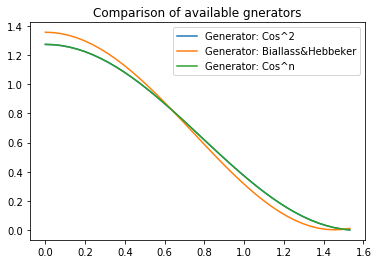

Testing angle generator: Cos^2


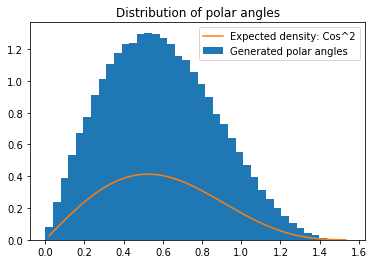

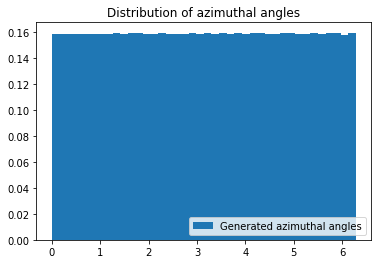

Testing angle generator: Biallass&Hebbeker


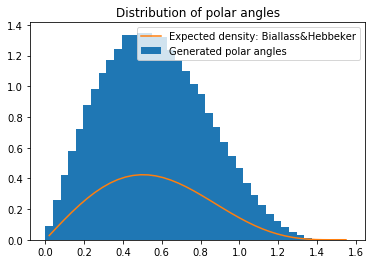

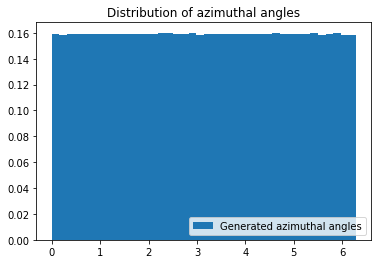

Testing angle generator: Cos^n


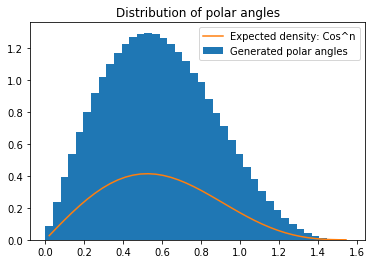

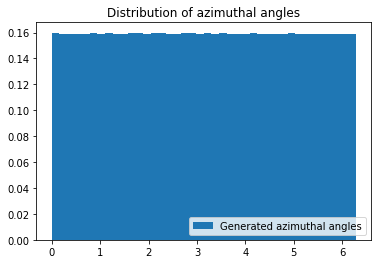

In [4]:
num_bins = 40
events_to_generate = 10000000

# compare available gnerators
plot_available_angle_generators(num_bins)


for key in available_angle_generators.keys():
    print("Testing angle generator: "+key)
    test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, angle_density_function_name=key)
    test_angel_gnerator(test_det, num_bins, events_to_generate)


#### Point generator tests

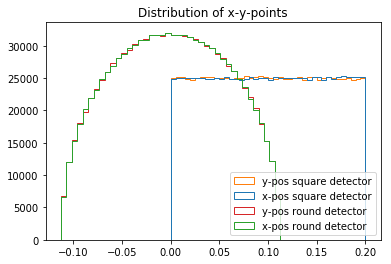

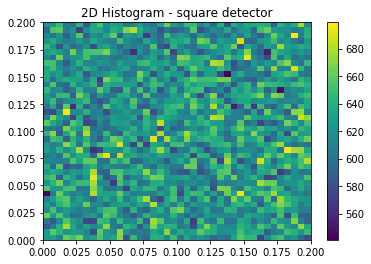

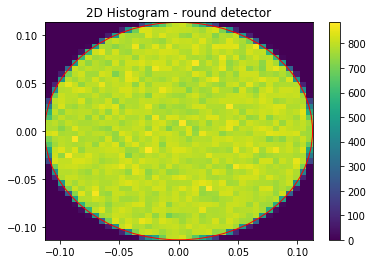

In [5]:
test_det_non_round = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size)
test_det_round = Simulated_Detector(scintillator_slab_geometry, True, scintillator_eff, discrete_probability_step_size)

num_bins = 40
events_to_generate = 1000000
test_pos_non_round = test_det_non_round._generate_positions(num_pos = events_to_generate)
test_pos_round = test_det_round._generate_positions(num_pos = events_to_generate)

plt.title("Distribution of x-y-points")
n, bins, patches = plt.hist((test_pos_non_round[...,0], test_pos_non_round[...,1]), bins=num_bins, histtype='step', stacked=False, label=["x-pos square detector","y-pos square detector"])
n, bins, patches = plt.hist((test_pos_round[...,0], test_pos_round[...,1]), bins=num_bins, histtype='step', stacked=False, label=["x-pos round detector","y-pos round detector"])
plt.legend(loc="lower right")
plt.show()

plt.title("2D Histogram - square detector")
plt.hist2d(test_pos_non_round[...,0], test_pos_non_round[...,1], bins=num_bins)
plt.colorbar()
plt.show()

fig, ax = plt.subplots()
plt.title("2D Histogram - round detector")
plt.hist2d(test_pos_round[...,0], test_pos_round[...,1], bins=num_bins)
ax.add_artist(plt.Circle((0, 0), radius = np.sqrt(test_det_round.get_detector_area()/np.pi), color='r', fill=False))
plt.colorbar()
plt.show()

#### Filter tests

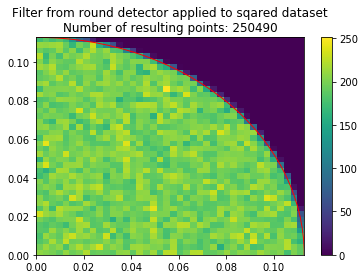

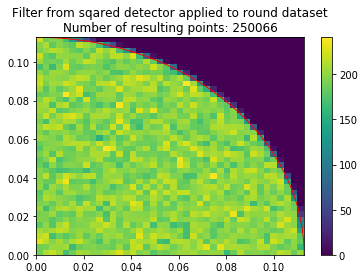

In [6]:
# let the round detector filter the sqared positions
filtered = test_det_round._filter_out_of_bounds(test_pos_non_round)
fig, ax = plt.subplots()
plt.title("Filter from round detector applied to sqared dataset\nNumber of resulting points: {0:d}".format(len(filtered)))
plt.hist2d(filtered[...,0], filtered[...,1], bins=num_bins)
ax.add_artist(plt.Circle((0, 0), radius = np.sqrt(test_det_round.get_detector_area()/np.pi), color='r', fill=False))
plt.colorbar()
plt.show()

# let the sqared detector filter the round positions
filtered = test_det_non_round._filter_out_of_bounds(test_pos_round)
fig, ax = plt.subplots()
plt.title("Filter from sqared detector applied to round dataset\nNumber of resulting points: {0:d}".format(len(filtered)))
plt.hist2d(filtered[...,0], filtered[...,1], bins=num_bins)
ax.add_artist(plt.Circle((0, 0), radius = np.sqrt(test_det_round.get_detector_area()/np.pi), color='r', fill=False))
plt.colorbar()
plt.show()

In [7]:
test_det_sqared = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size)
print(test_det_sqared.simulate_rate(current_setup_distance, simulation_lenght_seconds))

test_det_round = Simulated_Detector(scintillator_slab_geometry, True, scintillator_eff, discrete_probability_step_size)
print(test_det_round.simulate_rate(current_setup_distance, simulation_lenght_seconds))

[ 5.14046356  0.01177359]
[ 5.23514098  0.01188152]


#### Speed tests
For more detailed statistics uncomment the prun magic flag

In [10]:
speed_test_detector_time = 60*60*10.
speed_test_itterations = 100

In [11]:
#%%prun
wall_times = []
for i in range(speed_test_itterations):
    start_time = time.time()
    test_det_sqared = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size)
    test_det_sqared.simulate_rate(current_setup_distance, speed_test_detector_time)
    wall_times.append(time.time() - start_time)

wall_times = np.asarray(wall_times)
speeds = speed_test_detector_time/60/60/wall_times

print("Sqared detector: Simulated hours per second of wall time = {0:.1f} +- {1:.1f} [h/s]".format(speeds.mean(), speeds.std()))

Sqared detector: Simulated hours per second of wall time = 96.0 +- 12.1 [h/s]


In [12]:
#%%prun
wall_times = []
for i in range(speed_test_itterations):
    start_time = time.time()
    test_det_round = Simulated_Detector(scintillator_slab_geometry, True, scintillator_eff, discrete_probability_step_size)
    test_det_round.simulate_rate(current_setup_distance, speed_test_detector_time)
    wall_times.append(time.time() - start_time)

wall_times = np.asarray(wall_times)
speeds = speed_test_detector_time/60/60/wall_times

print("Round detector: Simulated hours per second of wall time = {0:.1f} +- {1:.1f} [h/s]".format(speeds.mean(), speeds.std()))

Round detector: Simulated hours per second of wall time = 90.2 +- 7.6 [h/s]


## Simulate acceptance loss with detector distance

### Compare different angle generators

In [13]:
distances_to_simulate = np.arange(0.01, 1., 0.01)
rates_list = []

generator_keys = list(available_angle_generators.keys())

for key in generator_keys:
    print("Running angle generator: "+key)
    test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, angle_density_function_name=key)
    rates_list.append(test_det.simulate_rate_over_distance_range(distances_to_simulate, simulation_lenght_seconds))
# addding the old angle generation method
test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, use_deprecated_angle_calculation=True)
rates_list.append(test_det.simulate_rate_over_distance_range(distances_to_simulate, simulation_lenght_seconds))


Running angle generator: Cos^2
Running angle generator: Biallass&Hebbeker
Running angle generator: Cos^n


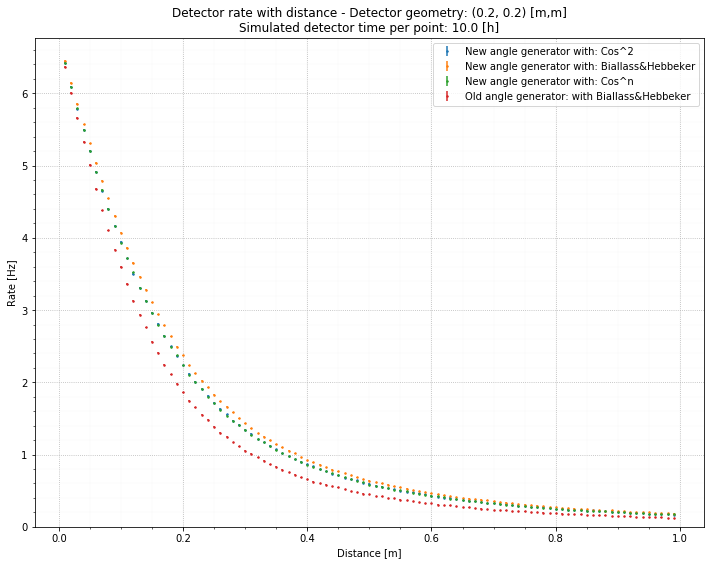

In [14]:
# create folder for the plot dump
directory = "plot_save/monte_carlo_rate/"
if not os.path.exists(directory):
    os.makedirs(directory)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

for i in range(len(generator_keys)):
    plt.errorbar(distances_to_simulate, rates_list[i][...,0],
             yerr=rates_list[i][...,1], fmt='.',
             markersize=3, label="New angle generator with: "+generator_keys[i])

plt.errorbar(distances_to_simulate, rates_list[len(rates_list)-1][...,0],
             yerr=rates_list[len(rates_list)-1][...,1], fmt='.',
             markersize=3, label="Old angle generator: with Biallass&Hebbeker")

ylims = (0., plt.ylim()[1])
#plt.vlines(x=scintillator_slab_thickness, ymin=0, ymax=ylims[1], linestyle='-.', color='r', label="Scintillator-box height")
#plt.vlines(x=current_setup_distance, ymin=0, ymax=ylims[1], linestyle='--', color='r', label="Current setup distance")
plt.ylim(ylims)

plt.legend()
plt.grid(which='major', linestyle=':')
plt.grid(which='minor', linestyle=':', linewidth=0.1)
title = "Detector rate with distance - Detector geometry: {0} [m,m]\n".format(scintillator_slab_geometry)
title += "Simulated detector time per point: {:0.1f} [h]".format(simulation_lenght_seconds/60./60.)
plt.title(title)
plt.xlabel("Distance [m]")
plt.ylabel("Rate [Hz]")
plt.savefig(directory+"Generator comparison.png")
plt.show()

### Compare to the analytical model

In [15]:
distances_to_simulate = np.arange(0.01, 1., 0.01)

simulated_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size)
simulated_det_round = Simulated_Detector(scintillator_slab_geometry, True, scintillator_eff, discrete_probability_step_size)

rate_actual_setup = simulated_det.simulate_rate_over_distance_range(distances_to_simulate, simulation_lenght_seconds)
rate_round_setup = simulated_det_round.simulate_rate_over_distance_range(distances_to_simulate, simulation_lenght_seconds)

'''
for i in range(len(distances_to_simulate)):
    current_dist = distances_to_simulate[i]
    rate_actual_setup[i] = simulated_det.simulate_rate(current_dist, simulation_lenght_seconds)
    faulty_rate_actual_setup[i] = faulty_simulated_det.simulate_rate(current_dist, simulation_lenght_seconds)
    rate_round_setup[i] = simulated_det_round.simulate_rate(current_dist, simulation_lenght_seconds)
'''

'\nfor i in range(len(distances_to_simulate)):\n    current_dist = distances_to_simulate[i]\n    rate_actual_setup[i] = simulated_det.simulate_rate(current_dist, simulation_lenght_seconds)\n    faulty_rate_actual_setup[i] = faulty_simulated_det.simulate_rate(current_dist, simulation_lenght_seconds)\n    rate_round_setup[i] = simulated_det_round.simulate_rate(current_dist, simulation_lenght_seconds)\n'

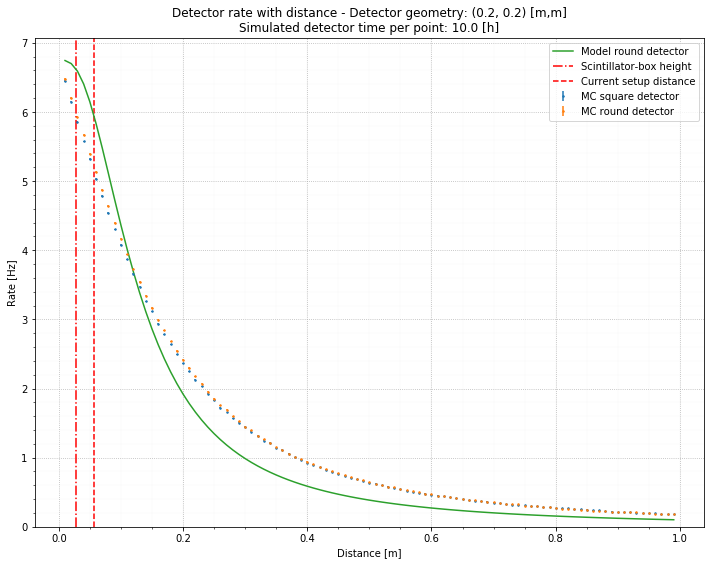

In [16]:
# create folder for the plot dump
directory = "plot_save/monte_carlo_rate/"
if not os.path.exists(directory):
    os.makedirs(directory)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.errorbar(distances_to_simulate, rate_actual_setup[...,0],
             yerr=rate_actual_setup[...,1], fmt='.',
             markersize=3, label="MC square detector")
plt.errorbar(distances_to_simulate, rate_round_setup[...,0],
             yerr=rate_round_setup[...,1], fmt='.',
             markersize=3, label="MC round detector")
plt.plot(distances_to_simulate, simulated_det_round.analytical_round_detector_rate(distances_to_simulate),
        label="Model round detector")
ylims = (0., plt.ylim()[1])
plt.vlines(x=scintillator_slab_thickness, ymin=0, ymax=ylims[1], linestyle='-.', color='r', label="Scintillator-box height")
plt.vlines(x=current_setup_distance, ymin=0, ymax=ylims[1], linestyle='--', color='r', label="Current setup distance")
plt.ylim(ylims)

plt.legend()
plt.grid(which='major', linestyle=':')
plt.grid(which='minor', linestyle=':', linewidth=0.1)
title = "Detector rate with distance - Detector geometry: {0} [m,m]\n".format(scintillator_slab_geometry)
title += "Simulated detector time per point: {:0.1f} [h]".format(simulation_lenght_seconds/60./60.)
plt.title(title)
plt.xlabel("Distance [m]")
plt.ylabel("Rate [Hz]")
plt.savefig(directory+"acc_geom_{0}_num-sim_{1:d}.png".format(str(scintillator_slab_geometry).replace(" ",""), events_to_generate))
plt.show()

### Legacy plot generation

In [17]:
events_to_generate = 100000
distances_to_simulate = np.arange(0.01, 1., 0.01)
loss_from_distances = []
loss_from_distances_errorous_angle_production = []
simulated_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size)

for distance in distances_to_simulate:
    loss_from_distances.append(simulated_det._simulate_loss_due_to_distance(distance, events_to_generate=events_to_generate))
    loss_from_distances_errorous_angle_production.append(simulated_det._simulate_loss_due_to_distance_old_kartesian(distance, events_to_generate=events_to_generate))
loss_from_distances = np.asarray(loss_from_distances)*100
loss_from_distances_errorous_angle_production = np.asarray(loss_from_distances_errorous_angle_production)*100

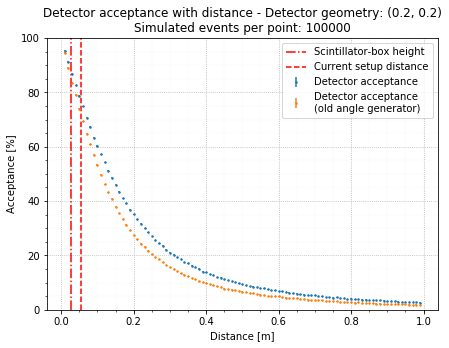

In [18]:
# create folder for the plot dump
directory = "plot_save/monte_carlo_acceptance/"
if not os.path.exists(directory):
    os.makedirs(directory)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

#plt.plot(distances_to_simulate, loss_from_distances[...,0], "b.", markersize=3, label="Detector efficency")
plt.errorbar(distances_to_simulate, loss_from_distances[...,0],
             yerr=loss_from_distances[...,1], fmt='.',
             markersize=3, label="Detector acceptance")
plt.errorbar(distances_to_simulate, loss_from_distances_errorous_angle_production[...,0],
             yerr=loss_from_distances_errorous_angle_production[...,1], fmt='.',
             markersize=3, label="Detector acceptance\n(old angle generator)")
plt.vlines(x=scintillator_slab_thickness, ymin=0, ymax=100, linestyle='-.', color='r', label="Scintillator-box height")
plt.vlines(x=current_setup_distance, ymin=0, ymax=100, linestyle='--', color='r', label="Current setup distance")

plt.legend()
plt.grid(which='major', linestyle=':')
plt.grid(which='minor', linestyle=':', linewidth=0.1)
title = "Detector acceptance with distance - Detector geometry: {0}\n".format(scintillator_slab_geometry)
title += "Simulated events per point: {:d}".format(events_to_generate)
plt.title(title)
plt.xlabel("Distance [m]")
plt.ylabel("Acceptance [%]")
plt.ylim((0,100))
plt.savefig(directory+"acc_geom_{0}_num-sim_{1:d}.png".format(str(scintillator_slab_geometry).replace(" ",""), events_to_generate))
plt.show()


In [19]:
# cosmicPi V1.5
#scintillator_slab_geometry_cosmicPi = (0.16, 0.098)
#detector_distance_cosmicPi = 0.05
#simulate_loss_due_to_distance(detector_distance_cosmicPi, scintillator_slab_geometry_cosmicPi, events_to_generate=10000000)

## Plot recorded data

### Only recorded data

In [19]:
# extract data from excel

path_to_excel_file = "C:/Users/Hendrik/OneDrive/active_sync_storage/Uni/MPIK/Bachelor/Teilchenwelt_detector/rate_with_distance_measurment.xlsx"
measured_data = pd.read_excel(path_to_excel_file)
measured_data = measured_data.sort_values(by=['distance [m]'])
measured_data = measured_data.reset_index(drop=True)

In [20]:
measured_data

,date,start time,distance [m],d distance [m],DAQ,time [s],count [1],d count [1],rate [Hz],d rate [Hz],Unnamed: 10,base_distance_error,revised distance errors,original distance errors,second revisiion
0,2017-11-23,14:35:00,0.056,0.004,NIM,1200,4850,69.641941,4.041667,0.058035,NaN,0.001,0.001,0.004,0.002
1,2017-11-27,15:00:00,0.056,0.004,NIM,1200,4891,69.935685,4.075833,0.058280,NaN,NaN,0.002,0.004,0.002
2,2017-11-27,15:25:00,0.084,0.004,NIM,1200,4059,63.710282,3.382500,0.053092,NaN,NaN,0.002,0.004,0.002
3,2017-11-27,12:50:00,0.104,0.004,NIM,1200,3682,60.679486,3.068333,0.050566,NaN,NaN,0.002,0.004,0.002
4,2017-11-23,15:05:00,0.122,0.004,NIM,1200,3209,56.648036,2.674167,0.047207,NaN,e.g. one scale unit,0.002,0.004,0.002
5,2017-11-27,13:10:00,0.170,0.004,NIM,1200,2536,50.358713,2.113333,0.041966,NaN,NaN,0.002,0.004,0.002
6,2017-11-23,16:15:00,0.212,0.008,NIM,1200,1936,44.000000,1.613333,0.036667,NaN,NaN,0.004,0.008,0.004
7,2017-11-27,13:32:00,0.234,0.004,NIM,1200,1754,41.880783,1.461667,0.034901,NaN,NaN,0.002,0.004,0.002
8,2017-11-23,16:37:00,0.265,0.012,NIM,1200,1519,38.974351,1.265833,0.032479,NaN,NaN,0.006,0.012,0.006
9,2017-11-23,17:15:00,0.327,0.016,NIM,1200,1123,33.511192,0.935833,0.027926,NaN,NaN,0.008,0.016,0.008


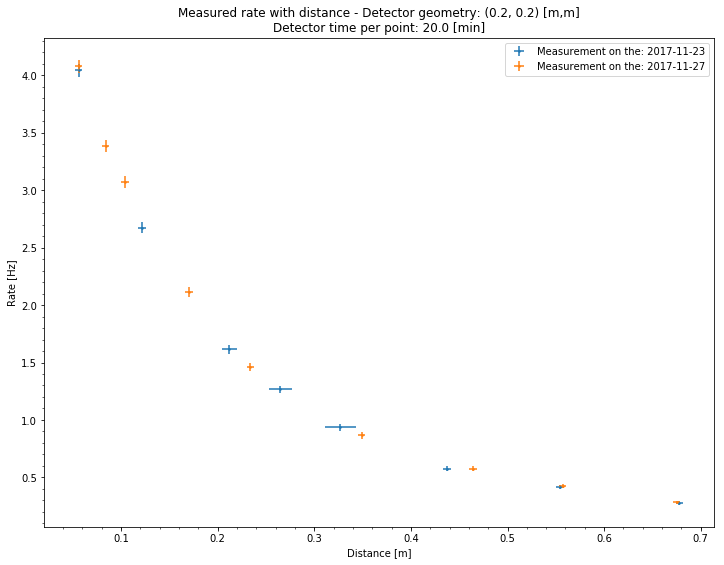

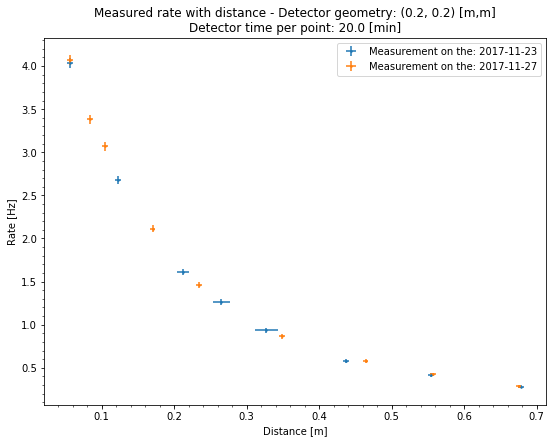

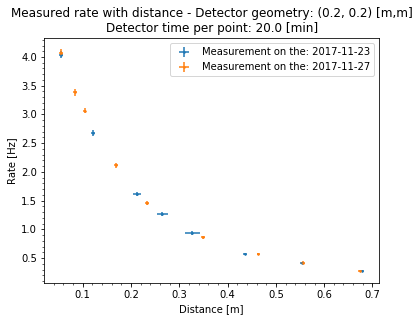

In [21]:
# create folder for the plot dump
directory = "plot_save/thesis_plots/"
if not os.path.exists(directory):
    os.makedirs(directory)

# create plot
for size_factor in (1., .75, .5):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    data_to_plot = measured_data.loc[measured_data['date'] == '2017-11-23']
    plt.errorbar(data_to_plot["distance [m]"], data_to_plot["rate [Hz]"],
                 yerr=data_to_plot["d rate [Hz]"], fmt='.', xerr=data_to_plot["d distance [m]"],
                 markersize=3, label="Measurement on the: 2017-11-23")

    data_to_plot = measured_data.loc[measured_data['date'] == '2017-11-27']
    plt.errorbar(data_to_plot["distance [m]"], data_to_plot["rate [Hz]"],
                 yerr=data_to_plot["d rate [Hz]"], fmt='.', xerr=data_to_plot["d distance [m]"],
                 markersize=3, label="Measurement on the: 2017-11-27")

    plt.legend()
    #plt.grid(which='major', linestyle=':')
    #plt.grid(which='minor', linestyle=':', linewidth=0.1)
    title = "Measured rate with distance - Detector geometry: {0} [m,m]\n".format(scintillator_slab_geometry)
    title += "Detector time per point: {:0.1f} [min]".format(1200/60.)
    plt.title(title)
    plt.xlabel("Distance [m]")
    plt.ylabel("Rate [Hz]")
    plt.savefig(directory+"measurement_results_size_{}.pdf".format(size_factor))
    plt.show()

## Confirm results from the numerical simulation in the MC simulation

In [22]:
# import data from numerical sim
with open("optimal_curves.pkl", "rb") as f:
    optimal_curves = pickle.load(f)

for key1 in optimal_curves.keys():
    print(key1)
    for key2 in optimal_curves[key1].keys():
        print("\t{}".format(key2))

parameters = optimal_curves

BH
	n_error
	Flux_err
	grid_steps
	n
	Flux
	chi^2_red
	y
	x
cos^n
	n_error
	Flux_err
	grid_steps
	n
	Flux
	chi^2_red
	y
	x


In [23]:
print optimal_curves['BH']['n']

0


In [24]:
print optimal_curves['cos^n']['n']

2.12875748361


In [61]:
simulation_lenght_seconds = 100*60*60

minimum_distance = measured_data["distance [m]"].min()
distances_to_simulate = np.asarray(optimal_curves['BH']['x'])
#distances_to_simulate = np.insert(distances_to_simulate, np.argwhere((distances_to_simulate>minimum_distance))[0][0], minimum_distance)
rates_list = {}
chi2_red = {}


for key in parameters.keys():
    print("Running angle generator: "+key+"; for time: "+str(simulation_lenght_seconds/60.)+" [min]")
    if key == 'BH':
        test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, angle_density_function_name='Biallass&Hebbeker')
    elif key == 'cos^n':
        test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, angle_density_function_name='Cos^n')
    else:
        print("I can't use the angel generator {}  mate".format(key))
        break
    test_det._additional_angle_distributions_parameters = {'n': parameters[key]["n"]}
    # do the calculation and discard the automatically calculated error
    rates_list[key] = test_det.simulate_rate_over_distance_range(distances_to_simulate, simulation_lenght_seconds)[...,0]
    # norm the rates
    rates_list[key] /= rates_list[key][0]
    rates_list[key] *= parameters[key]["Flux"]

[ 0.     0.02   0.04   0.056  0.06   0.08   0.1    0.12   0.14   0.16   0.18
  0.2    0.22   0.24   0.26   0.28   0.3    0.32   0.34   0.36   0.38   0.4
  0.42   0.44   0.46   0.48   0.5    0.52   0.54   0.56   0.58   0.6    0.62
  0.64   0.66   0.68   0.7    0.72   0.74   0.76   0.78   0.8  ]
[ 0.     0.02   0.04   0.056  0.06   0.08   0.1    0.12   0.14   0.16   0.18
  0.2    0.22   0.24   0.26   0.28   0.3    0.32   0.34   0.36   0.38   0.4
  0.42   0.44   0.46   0.48   0.5    0.52   0.54   0.56   0.58   0.6    0.62
  0.64   0.66   0.68   0.7    0.72   0.74   0.76   0.78   0.8  ]
Running angle generator: BH; for time: 6000.0 [min]
Running angle generator: cos^n; for time: 6000.0 [min]


In [62]:
sq_list = {}
chi_red_list = {}

for key in parameters.keys():
    sqs = []
    for i in range(len(parameters[key]['x'])):
        sq = parameters[key]['y'][i] - rates_list[key][i]
        sqs.append(sq)
    sqs = np.asarray(sqs)
    sq_list[key] = sqs
    chi_red_list[key] = np.sum(np.abs(sqs))/len(parameters[key]['x'])

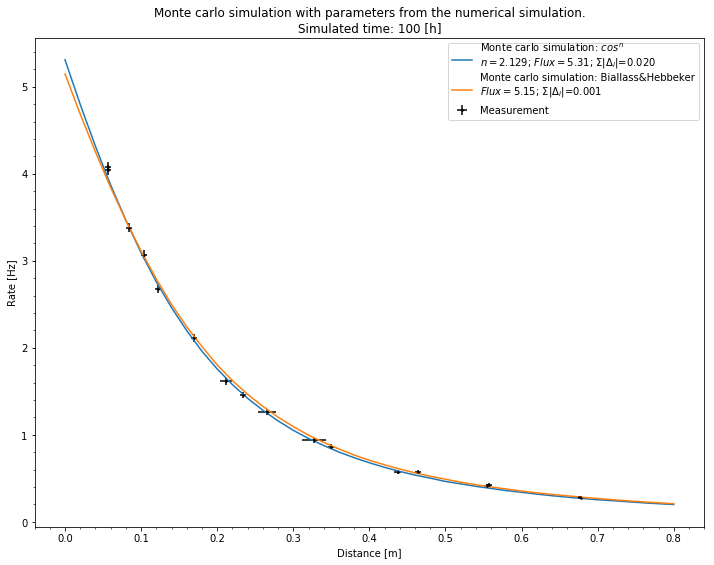

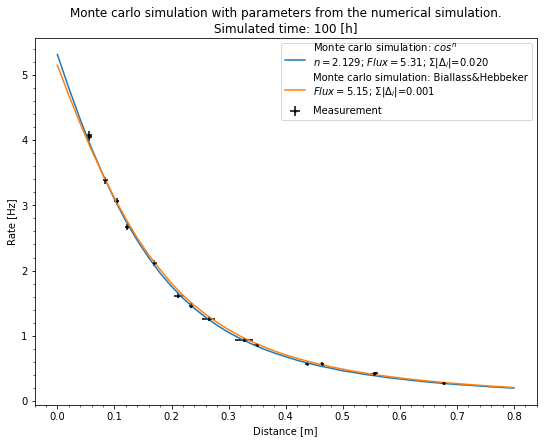

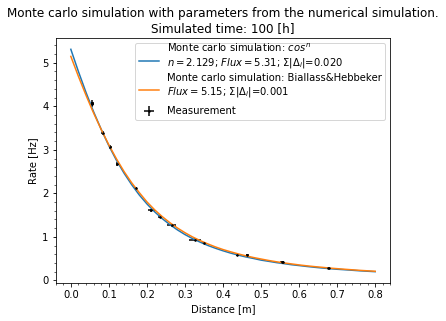

In [81]:
# create a combined plot
for size_factor in (1., .75, .5):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    
    key = "cos^n"
    curve_label = 'Monte carlo simulation: $cos^n$\n$n=%.3f$; $Flux=%.2f$; $\Sigma \|\Delta_i\|$=%0.3f' % (parameters[key]['n'], parameters[key]['Flux'], chi_red_list[key])
    plt.plot(distances_to_simulate, rates_list[key], label=curve_label)
    key = "BH"
    curve_label = 'Monte carlo simulation: Biallass&Hebbeker\n$Flux=%.2f$; $\Sigma \|\Delta_i\|$=%0.3f' % (parameters[key]['Flux'], chi_red_list[key])
    plt.plot(distances_to_simulate, rates_list[key], label=curve_label)
    
    plt.errorbar(measured_data["distance [m]"], measured_data["rate [Hz]"],
                 yerr=measured_data["d rate [Hz]"], fmt='.k', xerr=measured_data["d distance [m]"],
                 markersize=3, label="Measurement")

    plt.legend()
    title = "Monte carlo simulation with parameters from the numerical simulation.\n"
    title += "Simulated time: {:.0f} [h]".format(simulation_lenght_seconds/60/60)
    plt.title(title)
    plt.xlabel("Distance [m]")
    plt.ylabel("Rate [Hz]")
    plt.savefig(directory+"MC_size_{}_combined_plot_time_{}.pdf".format(size_factor, simulation_lenght_seconds))
    plt.show()

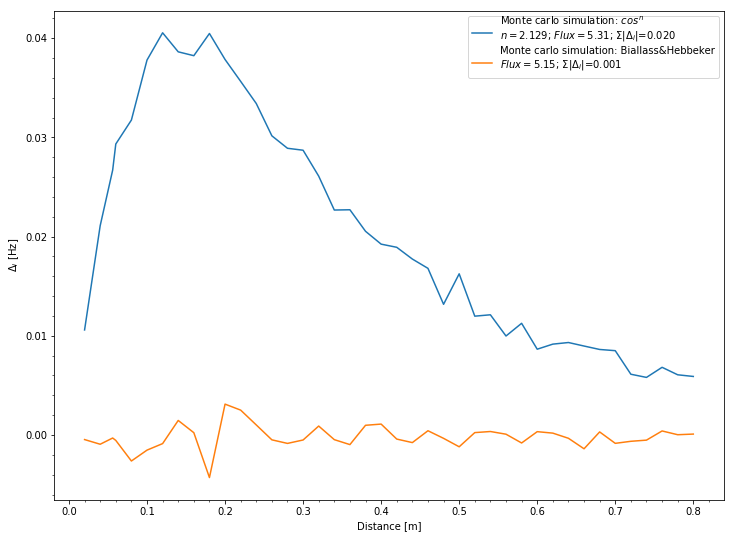

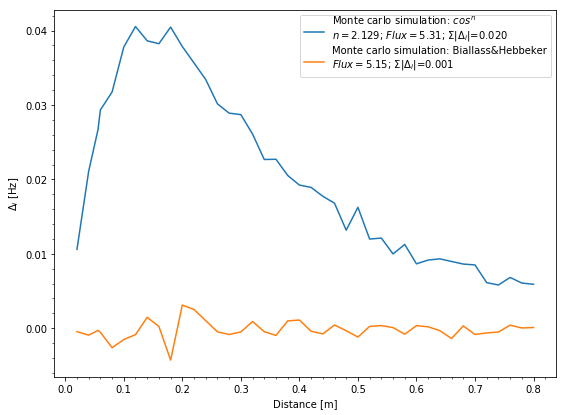

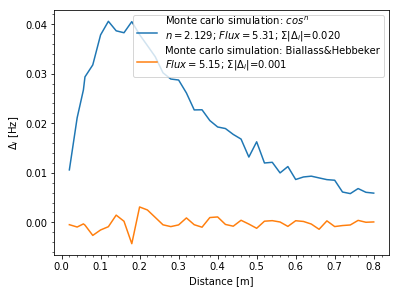

In [84]:
# create a difference plot
for size_factor in (1., .75, .5):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    key = "cos^n"
    curve_label = 'Monte carlo simulation: $cos^n$\n$n=%.3f$; $Flux=%.2f$; $\Sigma \|\Delta_i\|$=%0.3f' % (parameters[key]['n'], parameters[key]['Flux'], chi_red_list[key])
    plt.plot(distances_to_simulate[1:], sq_list[key][1:], label=curve_label)
    key = "BH"
    curve_label = 'Monte carlo simulation: Biallass&Hebbeker\n$Flux=%.2f$; $\Sigma \|\Delta_i\|$=%0.3f' % (parameters[key]['Flux'], chi_red_list[key])
    plt.plot(distances_to_simulate[1:], sq_list[key][1:], label=curve_label)

    plt.legend()
    title = "Monte carlo simulation with parameters from the numerical simulation.\n"
    title += "Simulated time: {:.0f} [h]".format(simulation_lenght_seconds/60/60)
    #plt.title(title)
    plt.xlabel("Distance [m]")
    plt.ylabel(r'$\Delta_i$ [Hz]')
    plt.savefig(directory+"MC_size_{}_difference_plot_time_{}.pdf".format(size_factor, simulation_lenght_seconds))
    plt.show()

In [10]:
# parameters from the numerical simulation
parameters_old = {
                "Biallass&Hebbeker": {
                    "n": 123,
                    "Flux": 5.145453988812990,
                    "Chi^2_red": 1.723265141656211
                },
                 "Cos^n": {
                     "n": 2.014161737754396,
                     "Flux": 5.366393086236847,
                     "Chi^2_red": 1.018335514581413
                 }
             }
parameters = {
                "Biallass&Hebbeker": {
                    "n": 123,
                    "Flux": 5.147244422792278,
                    "Chi^2_red": 0.767114692637744
                },
                 "Cos^n": {
                     "n": 2.128757483605487,
                     "Flux": 5.310141324155177,
                     "Chi^2_red": 0.616946094275487
                 }
             }

simulation_lenght_seconds = 100*60*60

minimum_distance = measured_data["distance [m]"].min()
distances_to_simulate = np.arange(0., .82, 0.02)
distances_to_simulate = np.insert(distances_to_simulate, np.argwhere((distances_to_simulate>minimum_distance))[0][0], minimum_distance)
rates_list = {}
chi2_red = {}

for key in parameters.keys():
    print("Running angle generator: "+key+"; for time: "+str(simulation_lenght_seconds/60.)+" [min]")
    test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, angle_density_function_name=key)
    test_det._additional_angle_distributions_parameters = {'n': parameters[key]["n"]}
    rates_list[key] = test_det.simulate_rate_over_distance_range(distances_to_simulate, simulation_lenght_seconds)
    # norm the rates
    rates_list[key] /= rates_list[key][0][0]
    rates_list[key] *= parameters[key]["Flux"]
    # calc chi^2_red
    rate_at_first_measurement = rates_list[key][np.argwhere((distances_to_simulate==minimum_distance))[0][0]]
    test_det.set_external_data(measured_data["distance [m]"], measured_data["d distance [m]"], measured_data["rate [Hz]"], measured_data["d rate [Hz]"], rate_at_first_measurement)
    chi2 = test_det._get_chi2_for_data(seconds_to_simulate=simulation_lenght_seconds)
    if "Cos" in key:
        chi2_red[key] = chi2/(len(measured_data["distance [m]"])-2)
    else:
        chi2_red[key] = chi2/(len(measured_data["distance [m]"])-1)


Running angle generator: Biallass&Hebbeker; for time: 6000.0 [min]
Running angle generator: Cos^n; for time: 6000.0 [min]


In [11]:
chi2_red

{'Biallass&Hebbeker': 1.8470953544795865, 'Cos^n': 1.4196026552877532}

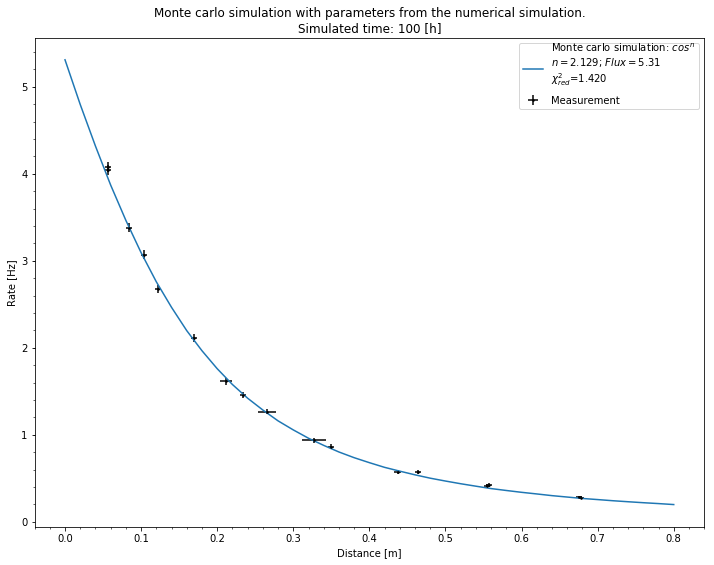

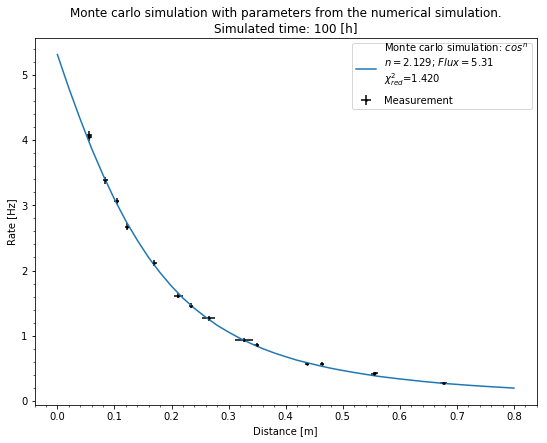

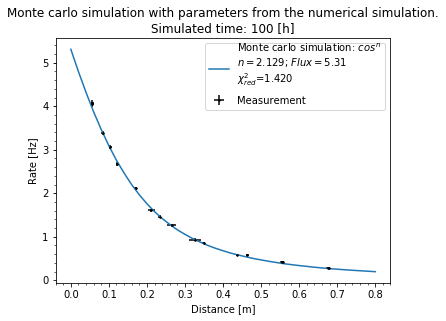

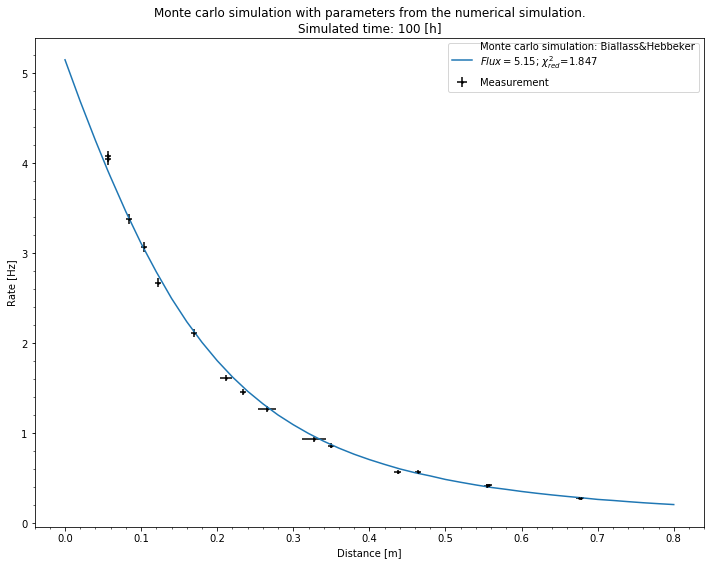

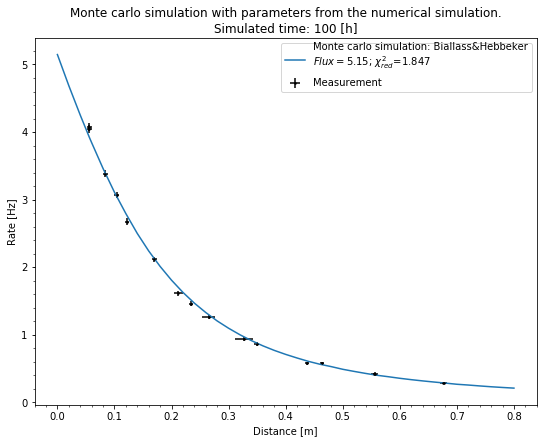

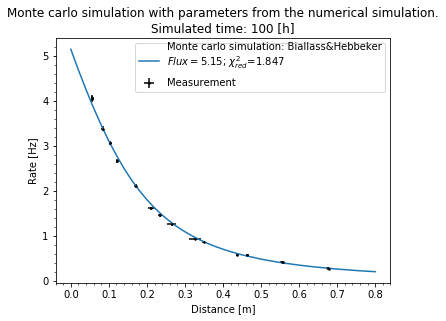

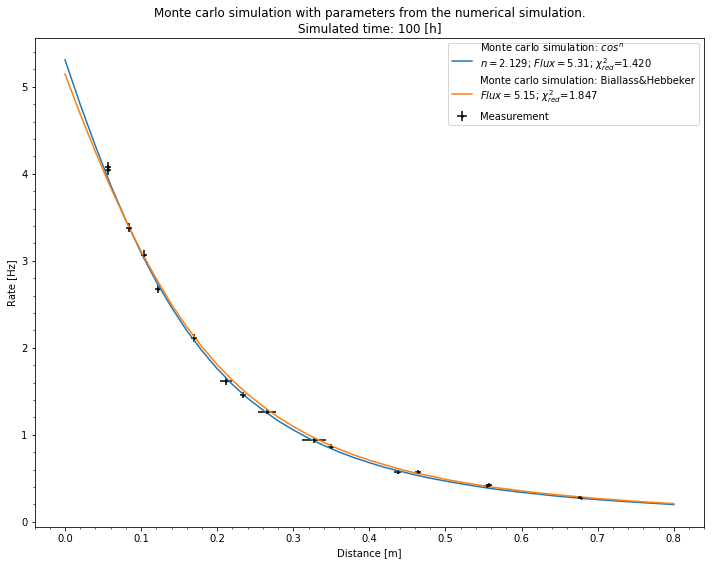

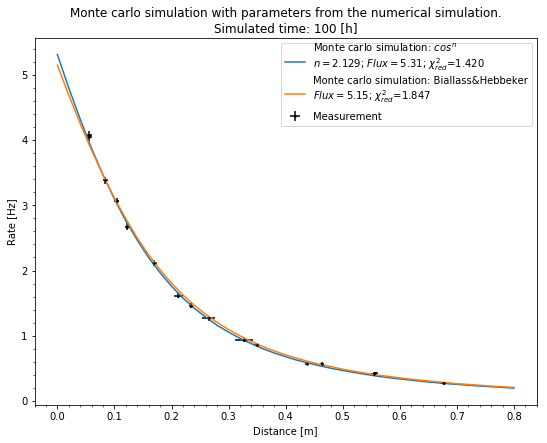

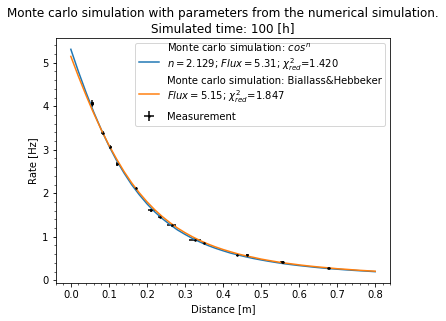

In [12]:
# create folder for the plot dump
directory = "plot_save/thesis_plots/"
if not os.path.exists(directory):
    os.makedirs(directory)
directory += "with_x_error_in_numerical_orig_syst_"
    
# create plot in different sizes
key = "Cos^n"
for size_factor in (1., .75, .5):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    
    curve_label = 'Monte carlo simulation: $cos^n$\n$n=%.3f$; $Flux=%.2f$\n$\chi^2_{red}$=%0.3f' % (parameters[key]['n'], parameters[key]['Flux'], chi2_red[key])
    plt.plot(distances_to_simulate, rates_list[key][...,0], label=curve_label)
    
    plt.errorbar(measured_data["distance [m]"], measured_data["rate [Hz]"],
                 yerr=measured_data["d rate [Hz]"], fmt='.k', xerr=measured_data["d distance [m]"],
                 markersize=3, label="Measurement")

    plt.legend()
    title = "Monte carlo simulation with parameters from the numerical simulation.\n"
    title += "Simulated time: {:.0f} [h]".format(simulation_lenght_seconds/60/60)
    plt.title(title)
    plt.xlabel("Distance [m]")
    plt.ylabel("Rate [Hz]")
    plt.savefig(directory+"MC_size_{}_distru_{}_time_{}.pdf".format(size_factor, key, simulation_lenght_seconds))
    plt.show()


# create plot in different sizes
key = "Biallass&Hebbeker"
for size_factor in (1., .75, .5):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    
    curve_label = 'Monte carlo simulation: Biallass&Hebbeker\n$Flux=%.2f$; $\chi^2_{red}$=%0.3f' % (parameters[key]['Flux'], chi2_red[key])
    plt.plot(distances_to_simulate, rates_list[key][...,0], label=curve_label)
    
    plt.errorbar(measured_data["distance [m]"], measured_data["rate [Hz]"],
                 yerr=measured_data["d rate [Hz]"], fmt='.k', xerr=measured_data["d distance [m]"],
                 markersize=3, label="Measurement")

    plt.legend()
    title = "Monte carlo simulation with parameters from the numerical simulation.\n"
    title += "Simulated time: {:.0f} [h]".format(simulation_lenght_seconds/60/60)
    plt.title(title)
    plt.xlabel("Distance [m]")
    plt.ylabel("Rate [Hz]")
    plt.savefig(directory+"MC_size_{}_distru_{}_time_{}.pdf".format(size_factor, key, simulation_lenght_seconds))
    plt.show()

# create a combined plot
for size_factor in (1., .75, .5):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    
    key = "Cos^n"
    curve_label = 'Monte carlo simulation: $cos^n$\n$n=%.3f$; $Flux=%.2f$; $\chi^2_{red}$=%0.3f' % (parameters[key]['n'], parameters[key]['Flux'], chi2_red[key])
    plt.plot(distances_to_simulate, rates_list[key][...,0], label=curve_label)
    key = "Biallass&Hebbeker"
    curve_label = 'Monte carlo simulation: Biallass&Hebbeker\n$Flux=%.2f$; $\chi^2_{red}$=%0.3f' % (parameters[key]['Flux'], chi2_red[key])
    plt.plot(distances_to_simulate, rates_list[key][...,0], label=curve_label)
    
    plt.errorbar(measured_data["distance [m]"], measured_data["rate [Hz]"],
                 yerr=measured_data["d rate [Hz]"], fmt='.k', xerr=measured_data["d distance [m]"],
                 markersize=3, label="Measurement")

    plt.legend()
    title = "Monte carlo simulation with parameters from the numerical simulation.\n"
    title += "Simulated time: {:.0f} [h]".format(simulation_lenght_seconds/60/60)
    plt.title(title)
    plt.xlabel("Distance [m]")
    plt.ylabel("Rate [Hz]")
    plt.savefig(directory+"MC_size_{}_combined_plot_time_{}.pdf".format(size_factor, key, simulation_lenght_seconds))
    plt.show()

### Measurements with normed simulation

In [23]:
# get our starting point as well as the rate to start with

minimum_distance = measured_data["distance [m]"].min()
rows_with_minimum = measured_data.loc[measured_data["distance [m]"] == minimum_distance]
lowest_distance_avg_rate = rows_with_minimum["rate [Hz]"].mean()

In [24]:
distances_to_simulate = np.arange(minimum_distance, 1., 0.01)

rates_list = []

generator_keys = list(available_angle_generators.keys())

for key in generator_keys:
    print("Running angle generator: "+key)
    test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, angle_density_function_name=key)
    rates_list.append(test_det.simulate_rate_over_distance_range(distances_to_simulate, simulation_lenght_seconds))
# addding the old angle generation method
test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, use_deprecated_angle_calculation=True)
rates_list.append(test_det.simulate_rate_over_distance_range(distances_to_simulate, simulation_lenght_seconds))


Running angle generator: Cos^2
Running angle generator: Biallass&Hebbeker
Running angle generator: Cos^n


In [25]:
# norm rates
for i in range(len(rates_list)):
    max_rate = rates_list[i][...,0].max()
    rates_list[i] /= max_rate
    rates_list[i] *= lowest_distance_avg_rate

model_norm = test_det.analytical_round_detector_rate(minimum_distance)

print("Calculating Chi^2 red for cos^2")
test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, angle_density_function_name="Cos^2")
test_det.set_external_data(measured_data["distance [m]"], measured_data["d distance [m]"], measured_data["rate [Hz]"], measured_data["d rate [Hz]"], lowest_distance_avg_rate)
chi2 = test_det._get_chi2_for_data(seconds_to_simulate=simulation_lenght_seconds)
chi2_red = chi2/len(measured_data["distance [m]"])

print("Calculating Chi^2 red for Biallass&Hebbeker")
test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, angle_density_function_name="Biallass&Hebbeker")
test_det.set_external_data(measured_data["distance [m]"], measured_data["d distance [m]"], measured_data["rate [Hz]"], measured_data["d rate [Hz]"], lowest_distance_avg_rate)
chi2_h = test_det._get_chi2_for_data(seconds_to_simulate=simulation_lenght_seconds)
chi2_red_h = chi2_h/len(measured_data["distance [m]"])

Calculating Chi^2 red for cos^2
Calculating Chi^2 red for Biallass&Hebbeker


In [26]:
chi2_red_h = chi2_h/len(measured_data["distance [m]"])

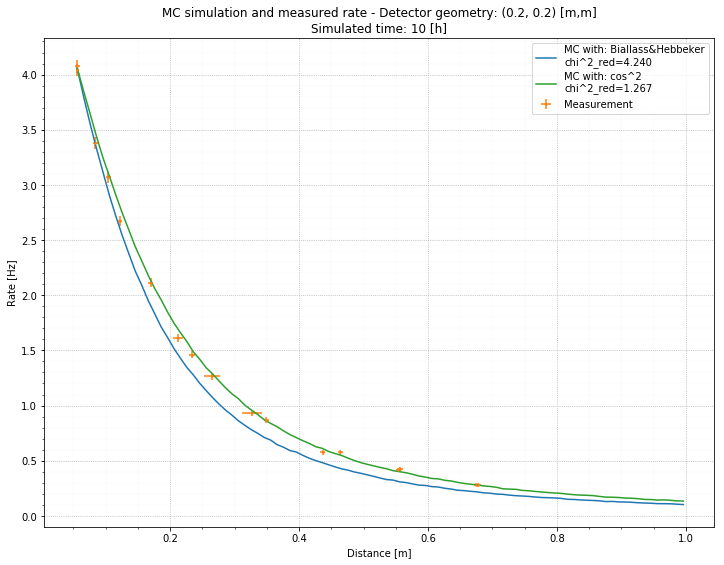

In [27]:
# create folder for the plot dump
directory = "plot_save/combined_mc_data/"
if not os.path.exists(directory):
    os.makedirs(directory)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

#for i in range(len(generator_keys)):
#    plt.plot(distances_to_simulate, rates_list[i][...,0], 
#             markersize=3, label="MC with: "+generator_keys[i])
#
plt.plot(distances_to_simulate, rates_list[len(rates_list)-1][...,0], 
             markersize=3, label="MC with: Biallass&Hebbeker\nchi^2_red={:0.3f}".format(chi2_red_h))

#plt.plot(distances_to_simulate, lowest_distance_avg_rate*test_det.analytical_round_detector_rate(distances_to_simulate)/model_norm,
#        label="Analytical model: round detector")
#
plt.errorbar(measured_data["distance [m]"], measured_data["rate [Hz]"],
             yerr=measured_data["d rate [Hz]"], fmt='.', xerr=measured_data["d distance [m]"],
             markersize=3, label="Measurement ")
plt.plot(distances_to_simulate, rates_list[0][...,0], 
             markersize=3, label="MC with: cos^2\nchi^2_red={:0.3f}".format(chi2_red))


plt.legend()
plt.grid(which='major', linestyle=':')
plt.grid(which='minor', linestyle=':', linewidth=0.1)
title = "Comparison measured rate, MC and analytical model\n"
title += "Models were normalized to the first measured point"
title = "MC simulation and measured rate - Detector geometry: {0} [m,m]\n".format(scintillator_slab_geometry)
title += "Simulated time: {:.0f} [h]".format(simulation_lenght_seconds/60/60)
plt.title(title)
plt.xlabel("Distance [m]")
plt.ylabel("Rate [Hz]")
plt.savefig(directory+"{0}_2.png".format(title.replace("\n", "_").replace(" ","_")[0:31]))
plt.show()

### Fit cos^n to the data

#### Fit via argument scan

In [41]:
test_det = Simulated_Detector(scintillator_slab_geometry, False, scintillator_eff, discrete_probability_step_size, angle_density_function_name="Cos^n")
test_det.set_external_data(measured_data["distance [m]"], measured_data["d distance [m]"], measured_data["rate [Hz]"], measured_data["d rate [Hz]"], lowest_distance_avg_rate)

# scan a parameter
parameter_name = 'n'
#parameter_range = np.arange(1, 3, 0.1)
parameter_range = np.arange(1.7, 2.1, 0.01)
# parameter range form Michael
#parameter_range = np.linspace(1.7, 2.4, 20)
seconds_to_simulate = 60*60*100

result1 = test_det.scan_angle_gnerator_parameter(parameter_name, parameter_range, seconds_to_simulate=seconds_to_simulate)

# get the parameter at the minimum of chi2
mini_parameter = result1.loc[result1['chi2'].idxmin()][parameter_name]

# fit a polinomya of degree = 2
def parabel(data, extrema_x, extrema_y, scaler):
    return scaler*(data-extrema_x)**2 + extrema_y

popt, pconv = curve_fit(parabel, result1[parameter_name], result1['chi2'])
popt_errors = np.sqrt(np.diag(pconv))
print("Minimum at: {0:.3f}+-{1:.3f}".format(popt[0], popt_errors[0]))

Current scan value: 1.70
Current scan value: 1.71
Current scan value: 1.72
Current scan value: 1.73
Current scan value: 1.74
Current scan value: 1.75
Current scan value: 1.76
Current scan value: 1.77
Current scan value: 1.78
Current scan value: 1.79
Current scan value: 1.80
Current scan value: 1.81
Current scan value: 1.82
Current scan value: 1.83
Current scan value: 1.84
Current scan value: 1.85
Current scan value: 1.86
Current scan value: 1.87
Current scan value: 1.88
Current scan value: 1.89
Current scan value: 1.90
Current scan value: 1.91
Current scan value: 1.92
Current scan value: 1.93
Current scan value: 1.94
Current scan value: 1.95
Current scan value: 1.96
Current scan value: 1.97
Current scan value: 1.98
Current scan value: 1.99
Current scan value: 2.00
Current scan value: 2.01
Current scan value: 2.02
Current scan value: 2.03
Current scan value: 2.04
Current scan value: 2.05
Current scan value: 2.06
Current scan value: 2.07
Current scan value: 2.08
Current scan value: 2.09


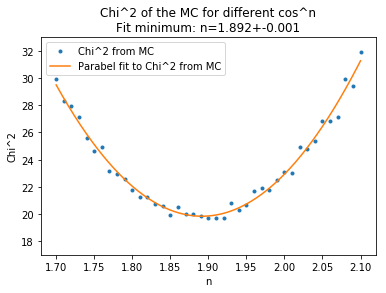

In [42]:
t = np.linspace(result1[parameter_name].min(), result1[parameter_name].max(), 500)
plt.plot(result1[parameter_name], result1['chi2'], '.', label="Chi^2 from MC")
plt.plot(t, parabel(t, *list(popt)), label="Parabel fit to Chi^2 from MC")
plt.xlabel(parameter_name)
plt.ylabel("Chi^2")
plt.ylim([17,33])
plt.legend()
title = "Chi^2 of the MC for different cos^n\n"
title += "Fit minimum: n={:.3f}+-{:.3f}".format(popt[0], popt_errors[0])
plt.title(title)
plt.savefig(directory+"MC_simulation_chi2_for_different_n_{:.1f}_to_{:.1f}.png".format(parameter_range[0],parameter_range[len(parameter_range)-1]))
plt.show()

#### Fit via minimizer

In [27]:
m = test_det.optimize_angle_generator_to_data(seconds_to_simulate=60*60*5)

Setting Minuit up
Running Minuit


FCN = 20.511049583881334 
 TOTAL NCALL = 34 
 NCALLS = 34 
 
 
 EDM = 0.0002989967363857815 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,n,2,0.000289286,0,0,0.1,4.0,


In [28]:
m.print_param()
print('parameters', m.parameters)
print('args', m.args)
print('value', m.values)
print('error', m.errors)

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,n,2,0.000289286,0,0,0.1,4.0,


parameters ['n']
args (2.0,)
value {'n': 2.0}
error {'n': 0.00028928626889246356}


## Unused code

In [29]:
def optimize_angle_generator_to_data(det, data_x, data_err_x, data_y, data_err_y, rate_to_norm_to, seconds_to_simulate=60*60*5):
        # check that the function actually supports optimizations
        generator_signature = inspect.signature(available_angle_generators[det._angle_density_function_name]).parameters
        if 'custom_args' not in dict(generator_signature):
            print("The angle generator {} does not support optimization!".format(det._angle_density_function_name))
            print("The generator has no optional parameter called 'custom_args', these are used for optimization. Please choose a different generator.")
            raise RuntimeError("The angle generator {} does not support optimization!".format(det._angle_density_function_name))
            return
        number_of_args_to_optimize = len(dict(generator_signature)['custom_args'].default)
        
        # function for the optimizer        
        def internal_func_to_optimize(x, custom_args=(1,)*number_of_args_to_optimize):
            print("Running simulation for {0:.1f} [h]".format(seconds_to_simulate/60/60))
            print(custom_args)
            # set the parameters that are beeing optimized
            det._additional_angle_generation_parameters = {'custom_args': (custom_args,)}
            # do the simulation
            rates = det.simulate_rate_over_distance_range(x, seconds_to_simulate)
            # reset the parameters again
            det._additional_angle_generation_parameters = None
            # scale the rates
            rates /= rates[...,0].max()
            rates *= rate_to_norm_to
            # we only need to return the simulated rates, not their errors
            return rates[...,0]
        print(inspect.signature(internal_func_to_optimize).parameters)
                
        # do something that is slightly vile
        # we change the signature of our function, dynamically
        # we start with writing down what the function wrapper should look like
        out_str = "def func_to_optimize(x"
        for i in range(10, number_of_args_to_optimize+10):
            out_str += ", cust{0:d}={0:d}".format(i)
        out_str += "):\n"
        out_str += "\treturn outer_fun(x, custom_args=("
        out_str += "cust{0:d}".format(10)
        for i in range(11, number_of_args_to_optimize+10):
            out_str += ", cust{0:d}".format(i)
        out_str += "))\n"
        
        print(out_str)
        
        # then we compile and evaluate this
        fakefunc_code = compile(out_str, "fakesource", "exec")
        fakeglobals = {}
        eval(fakefunc_code, {"outer_fun": internal_func_to_optimize}, fakeglobals)
        # this is our final function
        func_to_optimize = fakeglobals["func_to_optimize"]
        
        print(inspect.signature(func_to_optimize).parameters)
        print(func_to_optimize(np.ones(2)))
        
        
        data = pd.DataFrame.from_dict({'x':data_x, 'dx':data_err_x, 'y':data_y, 'dy':data_err_y})
        
        print("running optimizer")
        params = curve_fit(func_to_optimize, data["x"], data["y"])
        
        # return the resulting parameters
        return params
        

### 

In [9]:
# import data from numerical sim
with open("optimal_curves.pkl", "rb") as f:
    optimal_curves = pickle.load(f)

for key1 in optimal_curves.keys():
    print(key1)
    for key2 in optimal_curves[key1].keys():
        print("\t{}".format(key2))

BH
	n_error
	Flux_err
	grid_steps
	n
	Flux
	chi^2_red
	y
	x
cos^n
	n_error
	Flux_err
	grid_steps
	n
	Flux
	chi^2_red
	y
	x
